In [192]:
import numpy as np 
import pandas as pd
import pystan
import stan_utility
import scipy
import _pickle as cPickle


import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
import matplotlib.ticker as ticker


import seaborn as sns
import pandas as pd
import os

# to render plots with white background
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.75)



In [174]:
%%time
# These are the loaded dataframes that are calculated below

df_corr_all = pd.read_csv("data/int_pc_qvals_gcamp.csv", index_col = 0) # .dropna(subset=['Q_dir_diff'])


df_trials = pd.read_csv("data/int_pc_qvals.csv", index_col = 0)


# update the gcamp values from strings --> arrays of floats 
df_src = df_corr_all

df_src['g_np'] = df_src['g_np'].apply(
                        lambda line: np.array([float(val) for val in line[1:-1].replace('\n', '').split(' ') if val]))
df_src['g_lp'] = df_src['g_lp'].apply(
                        lambda line: np.array([float(val) for val in line[1:-1].replace('\n', '').split(' ') if val]))
df_src['g_choice'] = df_src['g_choice'].apply(
                        lambda line: np.array([float(val) for val in line[1:-1].replace('\n', '').split(' ') if val]))
df_src['g_reward'] = df_src['g_reward'].apply(
                        lambda line: np.array([float(val) for val in line[1:-1].replace('\n', '').split(' ') if val]))



CPU times: user 3.05 s, sys: 386 ms, total: 3.44 s
Wall time: 3.88 s


In [175]:
# some additional constants 

# for gcamp (dt = dt of gcamp recordings)
dt = 15
LEN_BEFORE = dt
LEN_AFTER = dt * 2
GCAMP_RANGE = np.arange(-1, 2, 1/dt)

# for trials in general 

NS = len(np.unique(df_trials['MouseID']))

NT = max(df_trials.groupby('MouseID').count()['Trial'])
NT_all = df_trials.groupby('MouseID').count()['Trial']

c_str = np.empty([NS, NT], 'str')
r = np.empty([NS, NT], int)
r.fill(-1) # init with nan to ensure that shorter trials dont' get false data 
for i, s in enumerate(np.unique(df_trials['MouseID'])):
    c_str[i, :NT_all[s]] = (df_trials[df_trials['MouseID'] == s])['Action'].values
    r[i, :NT_all[s]] = (df_trials[df_trials['MouseID'] == s])['Reward'].values
    
c = np.empty([NS, NT], int)
c.fill(-1)

c[c_str == 'C'] = 0; 
c[c_str == 'I'] = 1;  


standata = {'NS':NS,'NT':NT,'NT_all':NT_all, 
           'r':r, 'c':c}

# pystan.stan_rdump(standata, 'rl_behavioral.data.R')
# pickle.dump( standata, open( "standata.p", "wb" ) )

# Figure 1 



In [160]:
df_corr = pd.DataFrame(df_corr_all[df_corr_all['RecordLoc'] == 'DMS'])
RECORDLOC = 'DMS'

In [161]:
# get the cuts + the binnings 

# constants: 
AVG_TIME_COURSE = np.arange(15, 30) # time course to average over. 15:30 corresponds to 0 to 1.0 seconds at timelock
Q_BINS = 10
Q_BINS_QUANTILES = Q_BINS

    
    
df_corr['max_np'] = [max(x) for x in df_corr['g_np']]
df_corr['max_lp'] = [max(x) for x in df_corr['g_lp']]
df_corr['max_ch'] = [max(x) for x in df_corr['g_choice']]
df_corr['max_r'] = [max(x) for x in df_corr['g_reward']]

df_corr['avg_np'] = [np.mean(x[AVG_TIME_COURSE], 0) for x in df_corr['g_np']]
df_corr['avg_lp'] = [np.mean(x[AVG_TIME_COURSE], 0) for x in df_corr['g_lp']]
df_corr['avg_lp'] = [np.mean(x[AVG_TIME_COURSE], 0) for x in df_corr['g_choice']]
df_corr['avg_r'] = [np.mean(x[AVG_TIME_COURSE], 0) for x in df_corr['g_reward']]


df_corr['bQ_dir_diff'] = pd.cut(df_corr['Q_dir_diff'], Q_BINS)
df_corr['bQ_ch_diff'] = pd.cut(df_corr['Q_ch_diff'], Q_BINS)

# quantile cuts for raw Q values 
df_corr['bQ_chosen'] = pd.qcut(df_corr['Q_chosen'], Q_BINS_QUANTILES)
df_corr['bQ_c'] = pd.qcut(df_corr['Q_c'], Q_BINS_QUANTILES)

# Note that Q_i below is not the most accurate way of getting it 
# Q_DIR_DIFF = Q_C - Q_I 
# Q_I =  Q_C - Q_DIR_DIFF 
# however --> these are the averaged values of Q_C and Q_DIR_DIFF. If you eventually want Q_i, you'll want to derive it from the 
# 3K samples of Q_i, then average. 

# df_corr['bQ_i'] = pd.qcut(df_corr['Q_c'] - df_corr['Q_dir_diff'], Q_BINS_QUANTILES)


In [57]:
sns.color_palette("Oranges")

[(0.99557093425605536, 0.89079584775086507, 0.7855132641291811),
 (0.99215686274509807, 0.77699346405228753, 0.57270280661284123),
 (0.99215686274509807, 0.62805074971164943, 0.34226835832372166),
 (0.96484429065743949, 0.47100346020761247, 0.14197616301422528),
 (0.8782929642445213, 0.31990772779700116, 0.024405997693194924),
 (0.67686274509803923, 0.22089965397923875, 0.010749711649365626)]

In [156]:

Q_to_plot = 'Q_dir_diff'

figure = plt.figure(figsize=(36, 18))

for j, Q_to_plot in enumerate(['Q_dir_diff', 'Q_chosen', 'Q_ch_diff']):

    for i, [timelocked, tl_name, palette] in enumerate(zip(['g_np', 'g_lp', 'g_choice', 'g_reward'], 
                                                           ['NosePoke', 'Lever Presentation', 'Choice (Lever Press)', 'Reward'], 
                                                           ['Reds', 'Oranges','Purples', 'Greens'])):
        ax = plt.subplot2grid((4,3),(i, j),rowspan=1)

        if tl_name == 'Reward':
            categories = [0, 1]
            column = 'Reward'
        else:
            categories = ['Con', 'Ips']
            column = 'Action'

        qlims = np.unique(df_corr['b' + Q_to_plot].dropna())

        # legend plotting 1. colorbar for the q values 2. the 
        cmap = ListedColormap(sns.color_palette(palette, len(qlims)).as_hex())
        bounds = [x.left for x in qlims] + [qlims[-1].right]
        norm = matplotlib.colors.BoundaryNorm(boundaries = bounds, ncolors = len(qlims))
        dummy_plot = ax.scatter(bounds, bounds, c = bounds, cmap = cmap, norm = norm)
    #     dummy_plot = ax.scatter([], [], c = bounds, cmap = cmap, norm = norm)

        ax.cla()
        cbar = plt.colorbar(dummy_plot)
        cbar.set_label(Q_to_plot)


        for subcat, line_type in zip(categories, ['-', ':']):
            df_src = df_corr[df_corr[column] == subcat]

            ax.plot([], 'k', linestyle = line_type, label = column + ":" + str(subcat))



            for q_i, col in zip(qlims, sns.color_palette(palette, len(qlims))):

                x = np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15)
                y = np.mean(df_src[(df_src[Q_to_plot] > q_i.left) & (df_src[Q_to_plot] <= q_i.right)][timelocked], 0)
                error = np.std(y, axis = 0) / np.sqrt(NS)

                ax.plot(x, y, color = '#363737', linestyle = line_type)

                ax.fill_between(x, y-error, y+error, color = col, alpha = 0.8)
                plt.title('GCaMP timelocked at ' + tl_name + ' from ' + RECORDLOC)
                plt.ylabel('Normalized delta F/F')
                plt.xlabel('Time (s)')
                
        ax.legend()
    #     plt.legend(title = 'Q_Contra - Q_Ipsi of Last Trial', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.savefig('figs/Q_plots.png', dpi=180)
plt.close()
print('Done')


Done


In [155]:
def plot_gcamp(x, y, col = 'C0', line_type = '-', tl_name = 'TBD', src = RECORDLOC) :
                        
    error = np.std(y, axis = 0) / np.sqrt(NS)

    ax.plot(x, y, color = '#363737', linestyle = line_type)

    ax.fill_between(x, y-error, y+error, color = col, alpha = 0.6)
    plt.title('GCaMP timelocked at ' + tl_name + ' from ' + src)
    plt.ylabel('Normalized delta F/F')
    plt.xlabel('Time (s)')

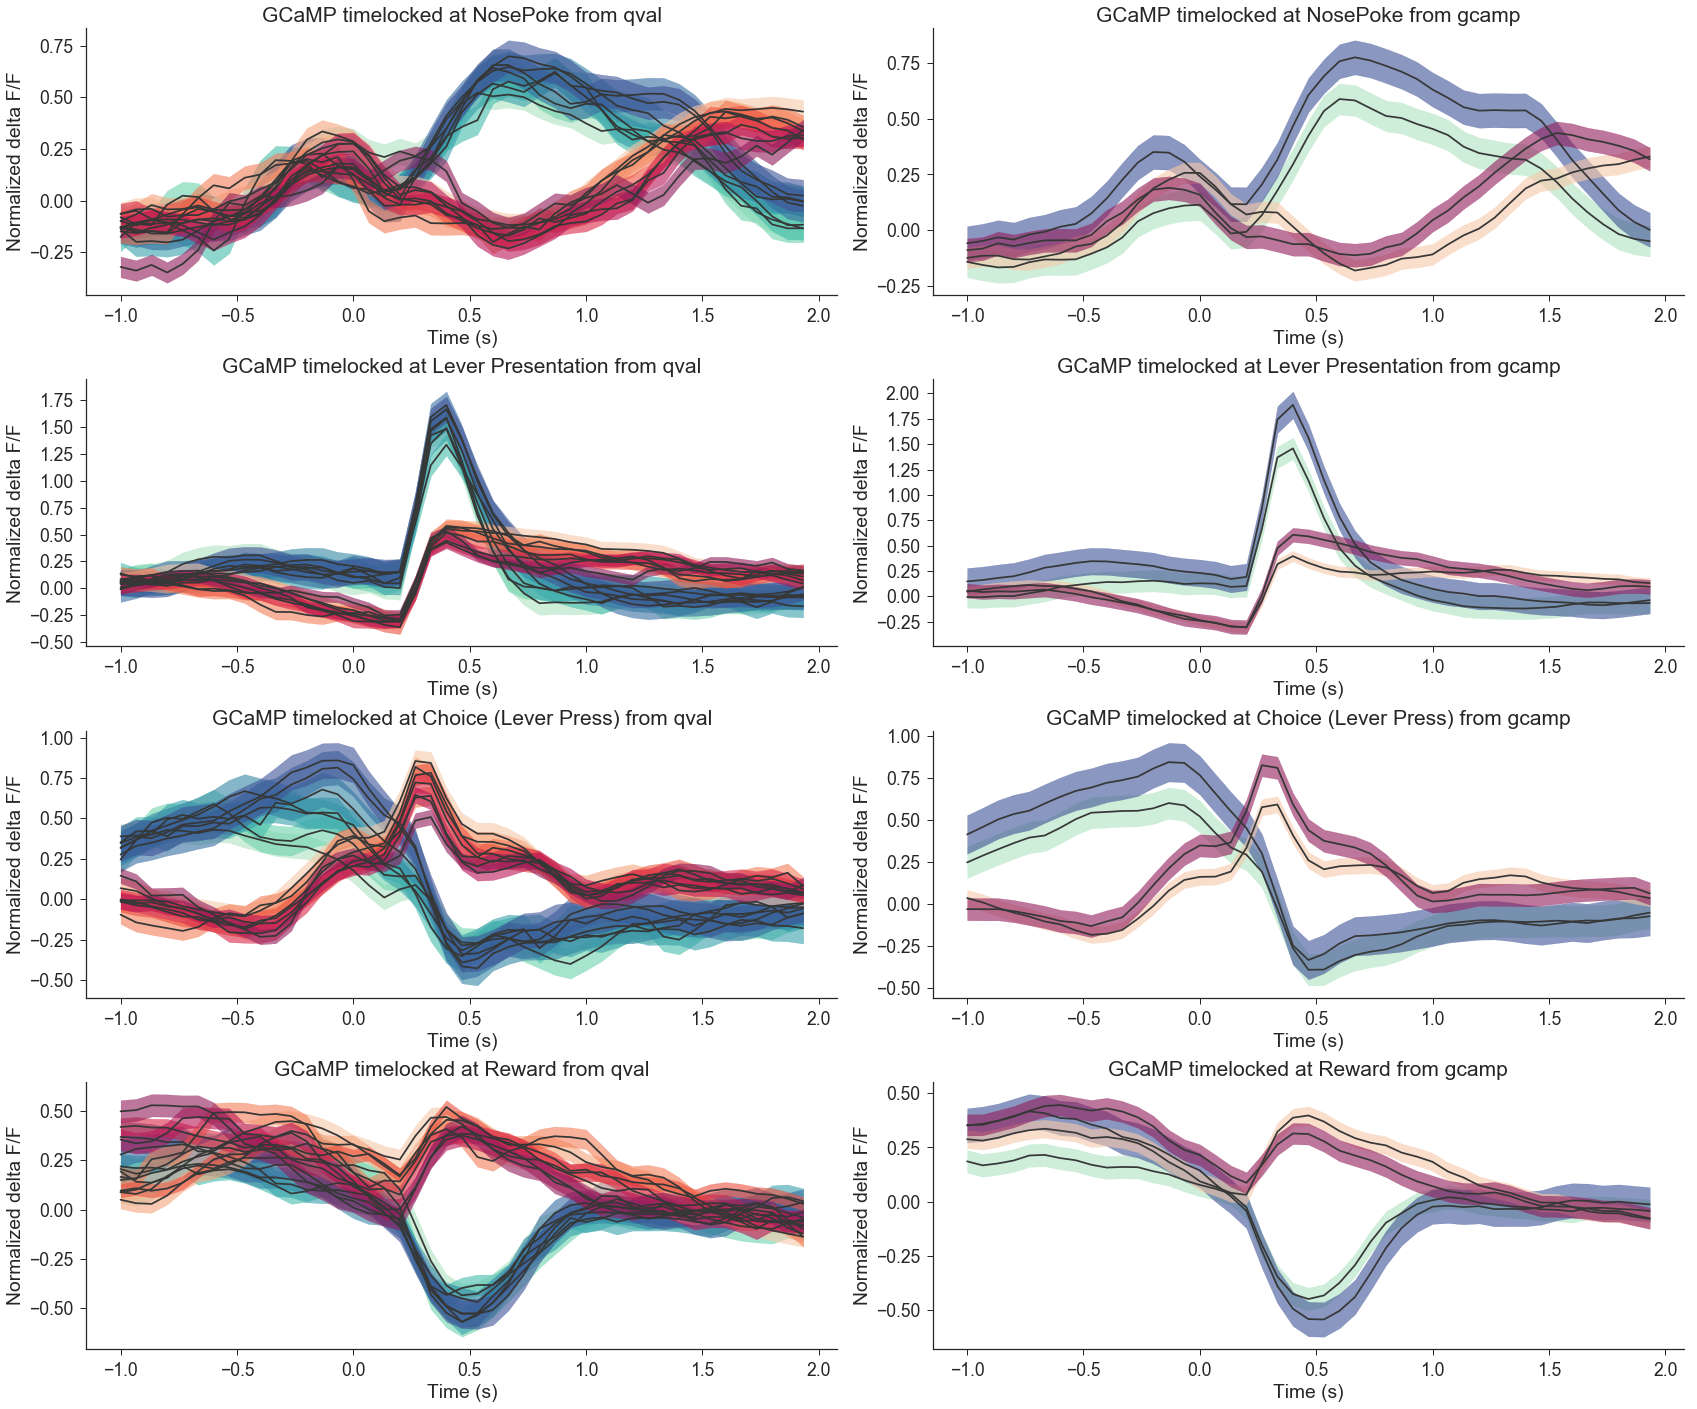

In [195]:
# RAW PLOT WITH NO LEGENDS 
# sns.set_style("whitegrid")
sns.set_style('ticks')
Q_to_plot = 'Q_dir_diff'



figure = plt.figure(figsize=(24, 20))
qlims = np.unique(df_corr['b' + Q_to_plot].dropna())
palettes =  ['mako_r', 'rocket_r']
for j, [src, lines] in enumerate(zip(['qval', 'gcamp'], [qlims, np.arange(2)])):
    

    for i, [timelocked, tl_name] in enumerate(zip(['g_np', 'g_lp', 'g_choice', 'g_reward'], 
                                                           ['NosePoke', 'Lever Presentation', 'Choice (Lever Press)', 'Reward'])):

        if tl_name == 'Reward':
            categories = [0, 1]
            column = 'Reward'
        else:
            categories = ['Con', 'Ips']
            column = 'Action'
            
            

                                        
        # legend plotting 1. colorbar for the q values 


#         for palette in palettes:
#             color_palette = sns.color_palette(sns.color_palette(palette, len(qlims))[:-3])
  
#             cmap = ListedColormap(color_palette.as_hex())
#             bounds = [x.left for x in qlims] + [qlims[-1].right]
#             norm = matplotlib.colors.BoundaryNorm(boundaries = bounds, ncolors = len(qlims))
#             dummy_plot = ax.scatter(bounds, bounds, c = bounds, cmap = cmap, norm = norm)
#             ax.cla()
            
#             if src == 'qval' and i == 3:

#                 cbar = plt.colorbar(dummy_plot)
#                 if subcat_i == 0:
#                     cbar.set_label(Q_to_plot)


        ax = plt.subplot2grid((4,2),(i, j),rowspan=1)

        for subcat_i, [subcat, palette] in enumerate(zip(categories, palettes)):
            df_src = df_corr[df_corr[column] == subcat]
            color_palette = sns.color_palette(sns.color_palette(palette, len(qlims))[:-3])

       # you should just have qlims for qval, and rewarded/not rewarded last trial for gcamp ! 

            for l_i, col in zip(lines, color_palette):

                if src == 'qval':
                    x = np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15)
                    y = np.mean(df_src[(df_src[Q_to_plot] > l_i.left) & (df_src[Q_to_plot] <= l_i.right)][timelocked], 0)
                elif src == 'gcamp':
                    gcamp = np.vstack(df_src[(df_src['Reward_last'] == l_i)][timelocked])
                    x = np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15)
                    y = np.mean(gcamp, axis = 0)
                    col = color_palette[l_i * -1]

                error = np.std(y, axis = 0) / np.sqrt(NS)

                ax.plot(x, y, color = '#363737', linestyle = '-')

                ax.fill_between(x, y-error, y+error, color = col, alpha = 0.6)
#                 plt.ylim([-1.0, 2.0])
                ax.yaxis.set_major_locator(ticker.MultipleLocator(0.25))

                plt.title('GCaMP timelocked at ' + tl_name + ' from ' + src)
                plt.ylabel('Normalized delta F/F')
                plt.xlabel('Time (s)')



#         ax.legend()
    #     plt.legend(title = 'Q_Contra - Q_Ipsi of Last Trial', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout(w_pad = 0.5, h_pad = 0.5)
sns.despine()


In [172]:
plt.colorbar?

Signature: plt.colorbar(mappable=None, cax=None, ax=None, **kw)
Docstring:
Add a colorbar to a plot.

Function signatures for the :mod:`~matplotlib.pyplot` interface; all
but the first are also method signatures for the
:meth:`~matplotlib.figure.Figure.colorbar` method::

  colorbar(**kwargs)
  colorbar(mappable, **kwargs)
  colorbar(mappable, cax=cax, **kwargs)
  colorbar(mappable, ax=ax, **kwargs)

Parameters
----------
mappable :
    The :class:`~matplotlib.image.Image`,
    :class:`~matplotlib.contour.ContourSet`, etc. to
    which the colorbar applies; this argument is mandatory for the Figure
    :meth:`~matplotlib.figure.Figure.colorbar` method but optional for the
    pyplot :func:`~matplotlib.pyplot.colorbar` function, which sets the
    default to the current image.

cax : :class:`~matplotlib.axes.Axes` object, optional
    Axis into which the colorbar will be drawn

ax : :class:`~matplotlib.axes.Axes`, list of Axes, optional
    Parent axes from which space for a new colorba

# scrap

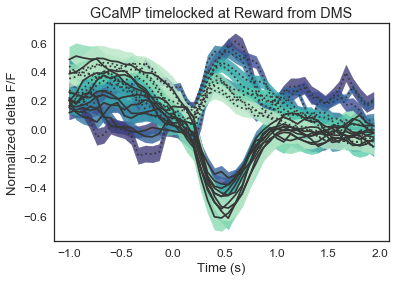

In [102]:
ax  = plt.subplot2grid((1,1), (0, 0))
# col = sns.choose_diverging_palette(, QBINS = 10)
foo = sns.color_palette("mako", 13)[3:]
for subcat, line_type in zip(categories, ['-', ':']):
    df_src = df_corr[df_corr[column] == subcat]

    ax.plot([], 'k', linestyle = line_type, label = column + ":" + str(subcat))
    for q_i, col in zip(qlims, foo):
        x = np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15)
        y = np.mean(df_src[(df_src[Q_to_plot] > q_i.left) & (df_src[Q_to_plot] <= q_i.right)][timelocked], 0)
        error = np.std(y, axis = 0) / np.sqrt(NS)


        ax.plot(x, y, color = '#363737', linestyle = line_type)

        ax.fill_between(x, y-error, y+error, color = col, alpha = 0.8)
        plt.title('GCaMP timelocked at ' + tl_name + ' from ' + RECORDLOC)
        plt.ylabel('Normalized delta F/F')
        plt.xlabel('Time (s)')


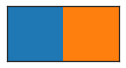

In [144]:
sns.palplot(['C0', 'C1'])

In [ ]:
sns.palplot(sns.cubehelix_palette(10, start = 3, rot = -1))

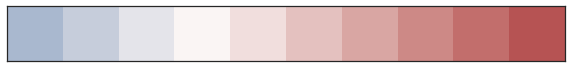

In [101]:
sns.palplot(sns.color_palette("vlag", 13)[3:])

# mako, rocket, icefire, vlag 

[array([ 0.25199714,  0.49873371,  0.57516028,  1.        ]),
 array([ 0.43026136,  0.62000665,  0.67878019,  1.        ]),
 array([ 0.60852558,  0.74127959,  0.7824001 ,  1.        ]),
 array([ 0.7867898 ,  0.86255253,  0.88602001,  1.        ]),
 array([ 0.95,  0.95,  0.95,  1.  ]),
 array([ 0.95457726,  0.76653099,  0.78032569,  1.        ]),
 array([ 0.91971827,  0.58735877,  0.61174   ,  1.        ]),
 array([ 0.88485928,  0.40818655,  0.44315432,  1.        ]),
 array([ 0.85104086,  0.23436275,  0.27960104,  1.        ])]

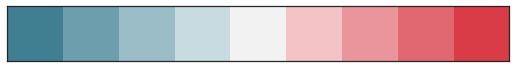

In [71]:
sns.choose_diverging_palette()